In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [231]:
def get_event_times(row):
    start_queue1 = row["tm_arrival_queue1"]
    tm_queue1 = row["tm_start_service1"] - start_queue1
    
    start_service1 = row["tm_start_service1"]
    tm_service1 = row["tm_end_service1"] - start_service1
    
    start_queue2 = row["tm_arrival_queue2"]
    tm_queue2 = row["tm_start_service2"] - start_queue2
    
    start_service2 = row["tm_start_service2"]
    tm_service2 = row["tm_end_service2"] - start_service2
    
    sequencia = [
        (start_queue1, tm_queue1), 
        (start_service1, tm_service1), 
        (start_queue2, tm_queue2),
        (start_service2, tm_service2)
    ]
    cores = ('tab:orange', 'tab:green', 'tab:red', 'tab:blue')
    
    return sequencia, cores

In [294]:
def resumo(arquivo, return_table=False):
    events = pd.read_csv(arquivo, index_col=0)
    
    # Horizontal bar plot with gaps
    fig, ax = plt.subplots(figsize=(15, 4))

    for i, idx in enumerate(events.index):
        seq, cores = get_event_times(events.loc[idx])    
        ax.broken_barh(seq, (i+0.75, 0.5), facecolors=cores)

    # ax.set_ylim(5, 35)
    # ax.set_xlim(0, 200)
    ax.set_xlabel('seconds since start')
    # ax.set_yticks([15, 25], labels=['Bill', 'Jim'])     # Modify y-axis tick labels
    ax.grid(True)                                       # Make grid lines visible


    legend = ('queue1', 'service1', 'queue2', 'service2')

    leg1 = mlines.Line2D([], [], color=cores[0], marker='s', ls='', label=legend[0])
    leg2 = mlines.Line2D([], [], color=cores[1], marker='s', ls='', label=legend[1])
    leg3 = mlines.Line2D([], [], color=cores[2], marker='s', ls='', label=legend[2])
    leg4 = mlines.Line2D([], [], color=cores[3], marker='s', ls='', label=legend[3])

    plt.legend(handles=[leg1, leg2, leg3, leg4], loc="upper left")

    plt.show()
    
    if return_table:  return events

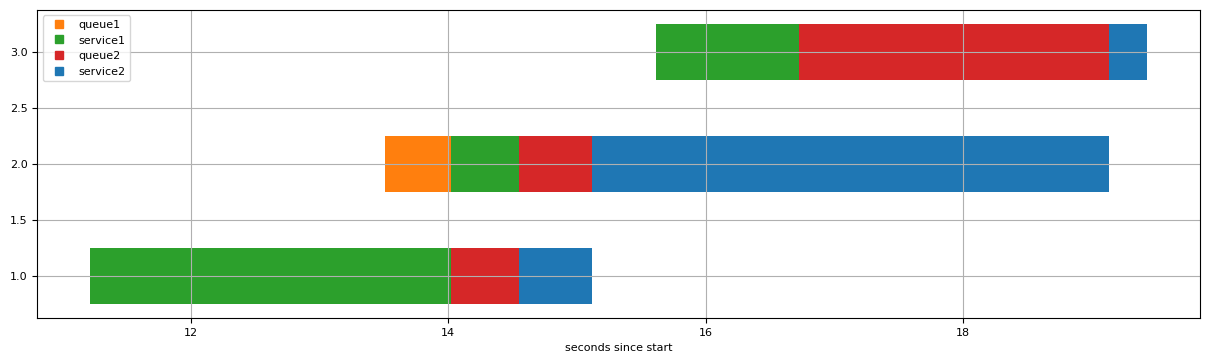

In [270]:
resumo("teste_retry.csv")

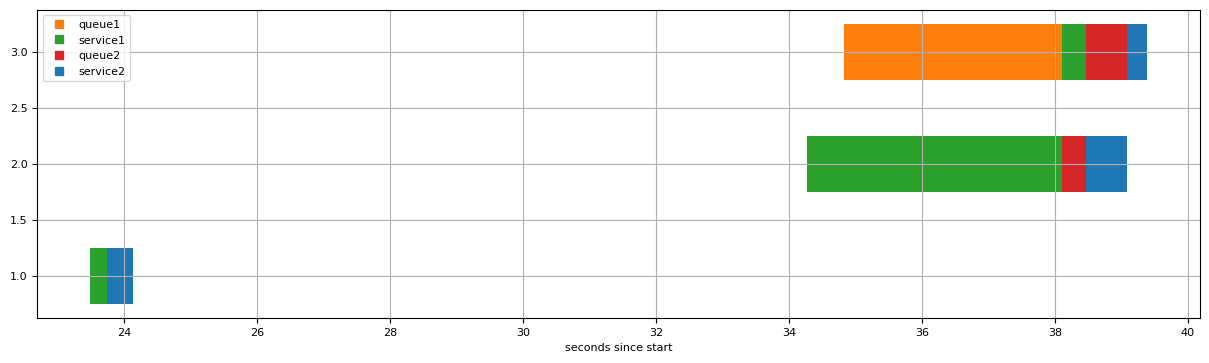

In [273]:
resumo("teste_prioridade.csv")

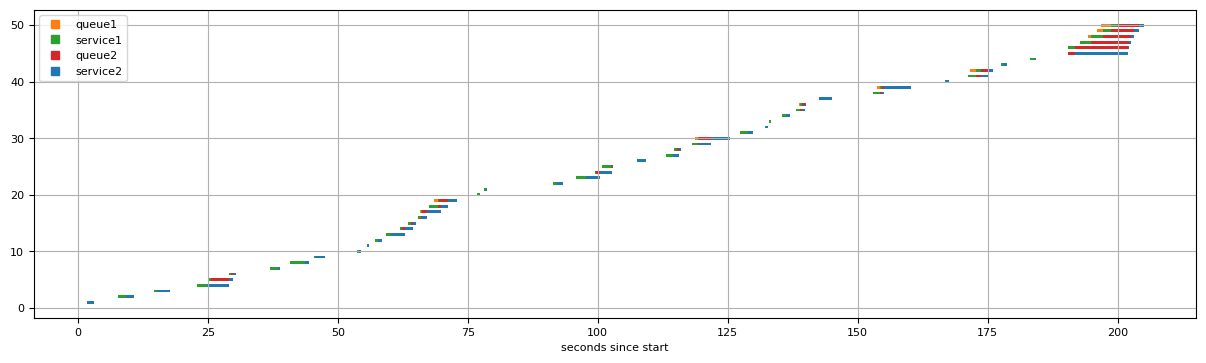

In [281]:
resumo("debug_aleatorio.csv")

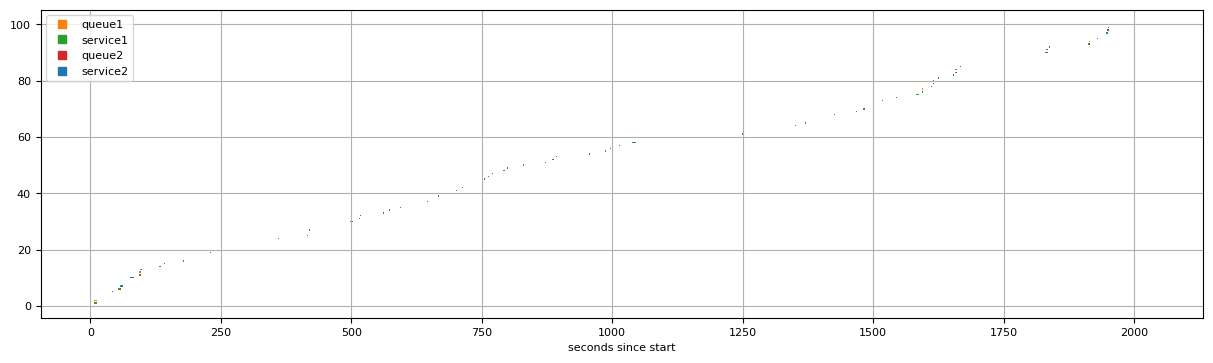

In [277]:
resumo("debug_aleatorio_01.csv")

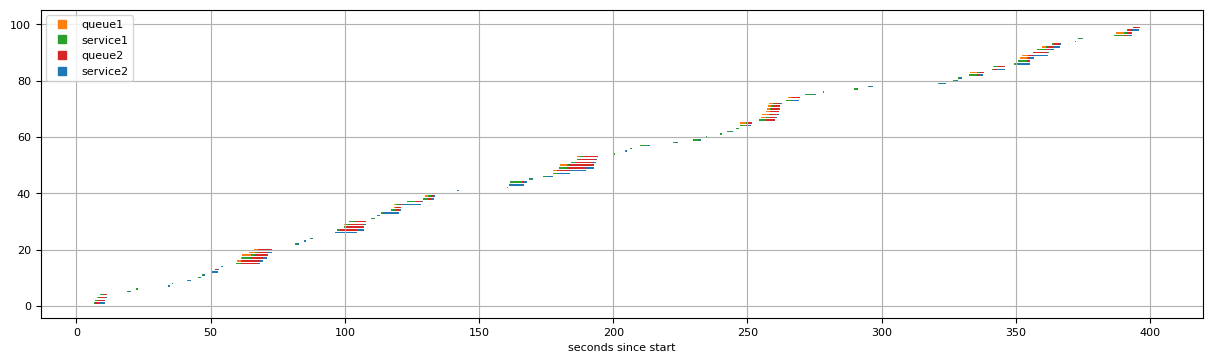

In [278]:
resumo("debug_aleatorio_05.csv")

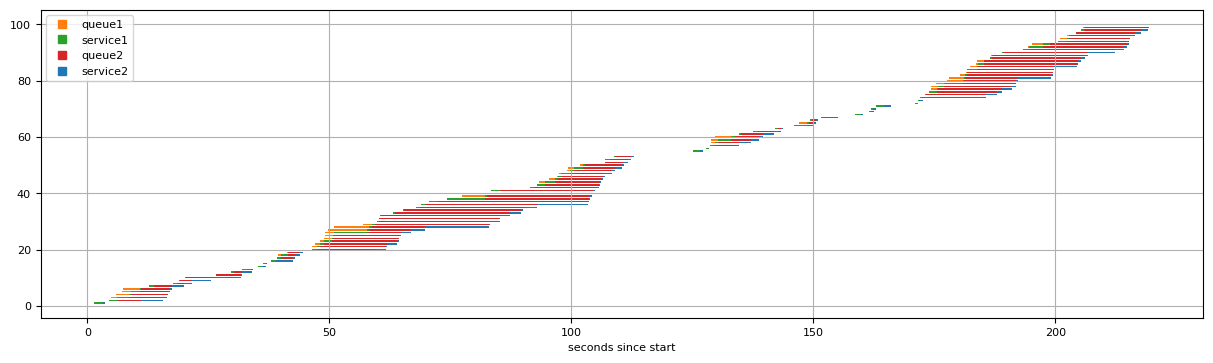

In [279]:
resumo("debug_aleatorio_09.csv")

## Simulador Deterministico

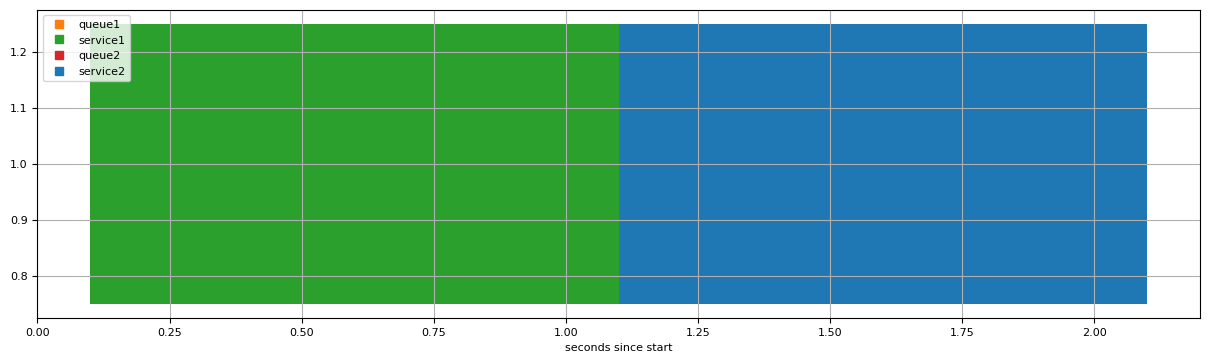

,tm_arrival,tm_service1,tm_service2,tm_arrival_queue1,tm_start_service1,tm_end_service1,tm_arrival_queue2,tm_start_service2,tm_end_service2
identifier,,,,,,,,,
1,0.1,1.0,1.0,0.1,0.1,1.1,1.1,1.1,2.1


In [298]:
# Teste de Fluxo
resumo("Validacoes Finais/teste_fluxo.csv", return_table = True)

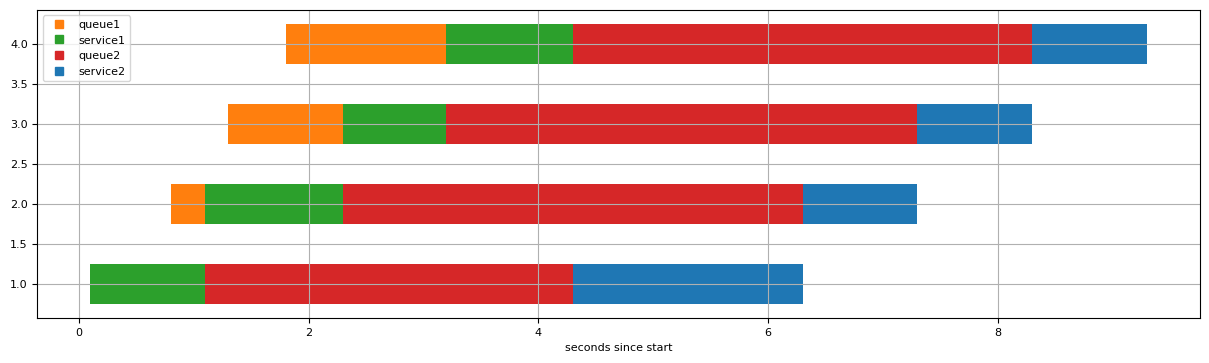

,tm_arrival,tm_service1,tm_service2,tm_arrival_queue1,tm_start_service1,tm_end_service1,tm_arrival_queue2,tm_start_service2,tm_end_service2
identifier,,,,,,,,,
1,0.1,1.0,2.0,0.1,0.1,1.1,1.1,4.3,6.3
2,0.8,1.2,1.0,0.8,1.1,2.3,2.3,6.3,7.3
3,1.3,0.9,1.0,1.3,2.3,3.2,3.2,7.3,8.3
4,1.8,1.1,1.0,1.8,3.2,4.3,4.3,8.3,9.3


In [300]:
# Teste de Prioridade
# Observe que cada servico ocorre apos o anterior terminar
# E que os clientes chegam na fila 1 antes do servico finalizar
# Entao quando um entra na fila 2 precisa aguardar todos da fila 1 terminarem
# Perceba que o servico 2 so inicia quando o ultimo servico 1 termina
resumo("Validacoes Finais/teste_prioridade.csv", return_table = True)

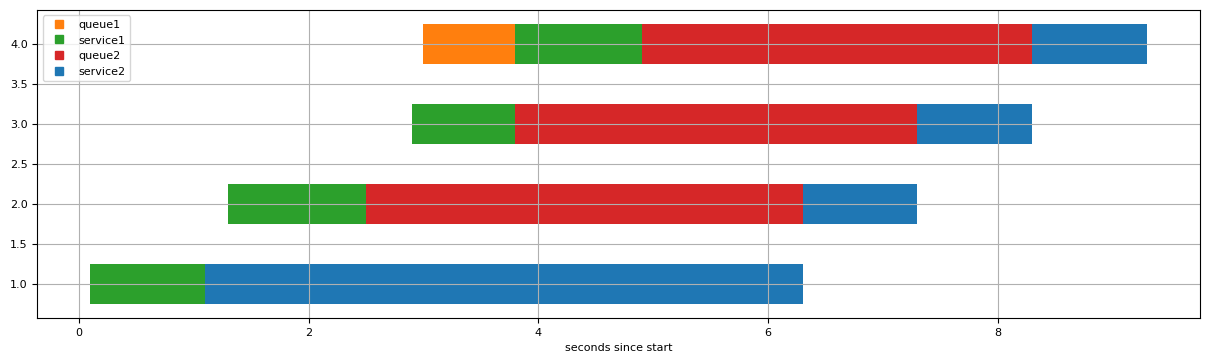

,tm_arrival,tm_service1,tm_service2,tm_arrival_queue1,tm_start_service1,tm_end_service1,tm_arrival_queue2,tm_start_service2,tm_end_service2
identifier,,,,,,,,,
1,0.1,1.0,2.0,0.1,0.1,1.1,1.1,1.1,6.3
2,1.3,1.2,1.0,1.3,1.3,2.5,2.5,6.3,7.3
3,2.9,0.9,1.0,2.9,2.9,3.8,3.8,7.3,8.3
4,3.0,1.1,1.0,3.0,3.8,4.9,4.9,8.3,9.3


In [302]:
# Teste de Interrupção
resumo("Validacoes Finais/teste_interrupcao.csv", return_table = True)

# Estatísticas

In [262]:
def get_statistics(row):
    start_queue1 = row["tm_arrival_queue1"]
    tm_queue1 = row["tm_start_service1"] - start_queue1
    
    start_service1 = row["tm_start_service1"]
    tm_service1 = row["tm_end_service1"] - start_service1
    
    start_queue2 = row["tm_arrival_queue2"]
    tm_queue2 = row["tm_end_service2"] - row["tm_service2"] - start_queue2
    
    tm_service2 = row["tm_service2"]
    
    return pd.Series({"tm_queue1": tm_queue1, "tm_service1": tm_service1, "tm_queue2": tm_queue2, "tm_service2": tm_service2})

In [263]:
events = pd.read_csv("teste_longo.csv", index_col=0)

In [264]:
statistics = events.apply(get_statistics, axis=1)

In [265]:
chunk_size = 1000
lim_superior = [chunk.mean() + 2 * chunk.std() for chunk in np.array_split(statistics["tm_queue1"], len(statistics)/chunk_size)]
lim_superior = pd.Series(lim_superior, index=range(0, len(lim_superior) * chunk_size, chunk_size))

<AxesSubplot: xlabel='identifier'>

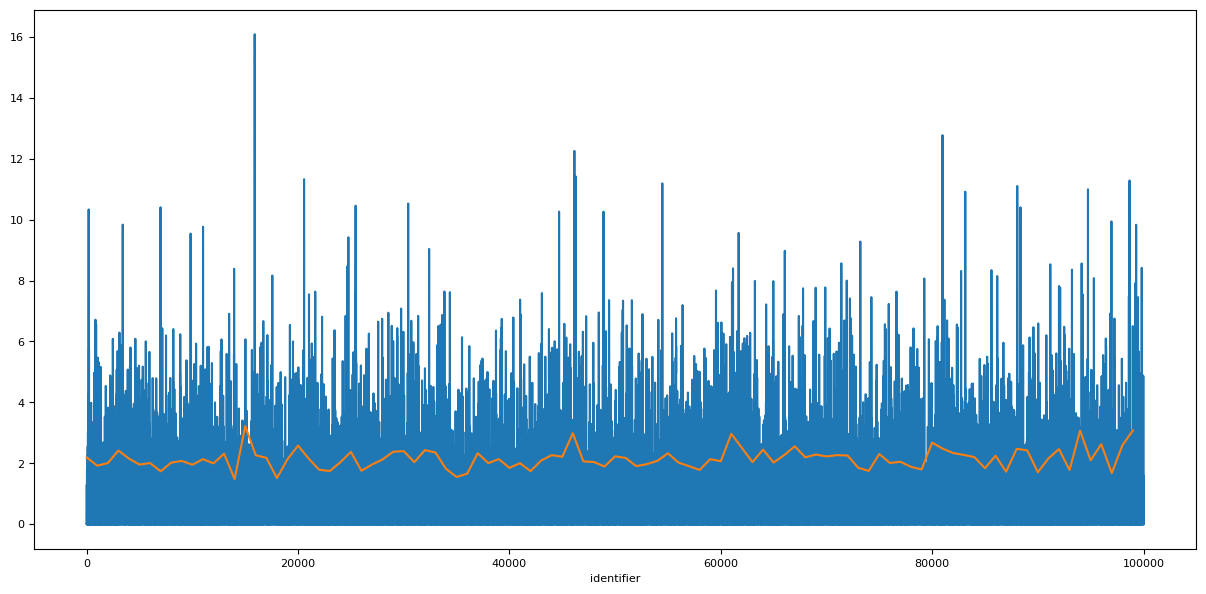

In [266]:
statistics["tm_queue1"].plot(figsize=(15,7))
lim_superior.plot(figsize=(15,7))

<AxesSubplot: xlabel='identifier'>

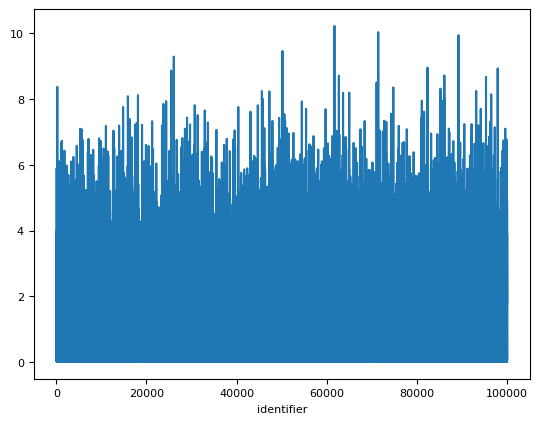

In [267]:
statistics["tm_service1"].plot()

<AxesSubplot: xlabel='identifier'>

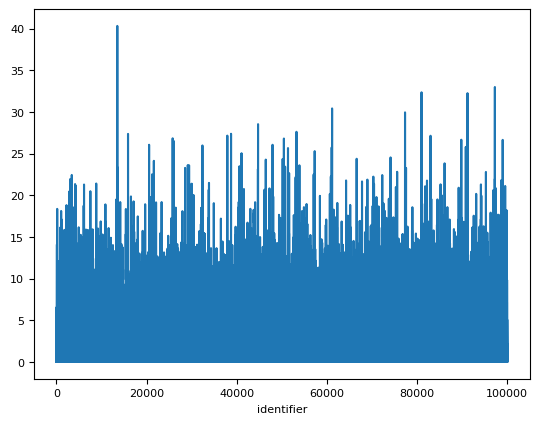

In [268]:
statistics["tm_queue2"].plot()

<AxesSubplot: xlabel='identifier'>

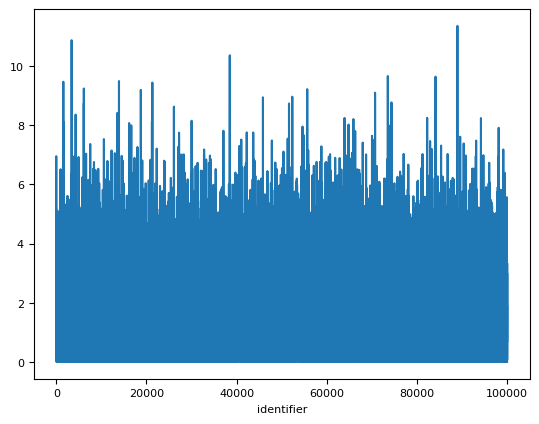

In [269]:
statistics["tm_service2"].plot()